<a href="https://colab.research.google.com/github/jonDuke/GAN_training/blob/main/MNIST/MNIST_GAN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST GAN

This notebook is following another tutorial, an official one from TensorFlow available here: https://www.tensorflow.org/tutorials/generative/dcgan

This tutorial demonstrates how to generate images of handwritten digits using a Deep Convolutional Generative Adversarial Network (DCGAN).  It uses the MNIST dataset to train, which is a well-known set of images of handwritten numbers.

The images are small, only 28x28 pixels, so it should train fast.  However the shapes are simple enough and images are all in black and white so it should be fairly easy to train a GAN to produce realistic looking images.

The only question is what the made-up symbols are going to look like!

In [1]:
# Check which version of Tensorflow we have installed
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

# Load and pre-process the data

The MNIST images are stored as 2D arrays, with values for each individual pixel in the 28x28 image.  Each number is a value from 0 to 255 representing the range between black and white.

Neural networks work much better with normalized data, so we convert that to the range [-1,1].

We also put the dataset into a Tensorflow class called [BatchDataset](https://www.tensorflow.org/api_docs/python/tf/raw_ops/BatchDataset), which predictably helps serve a dataset in batches.

In [3]:
# Load the images from TensorFlow's example libraries
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [4]:
# Reshapes the images array to put each pixel value into it's own array of length 1
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize image data from [0,255] to [-1, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print(train_images.shape)

(60000, 28, 28, 1)


In [5]:
# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
# The dataset is now encapsulated in this TensorFlow class which automatically serves data in batches
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

# Define the models

Both models are defined using the Keras sequential API

## The Generator

The generator is designed to take in a list of 100 random numbers (the latent space).  That is first fed into a fully-connected dense layer with 7*7*256 nodes.  

That is then reshaped to create a 7x7 grid, which gets upscaled using Conv2DTranspose layers to 14x14 then 28x28, matching the original image dimensions.

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

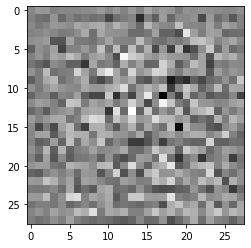

In [8]:
# To demonstrate, use the (untrained) generator model to create an image
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

## The Discriminator

The discriminator takes in the image array, which we ensured was shape [28,28,1].  That data goes through 2 Conv2D layers, flattened, then fed into a Dense layer with just one node, giving the final output of one digit between 0 and 1.

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
# Use the discriminator to decide if the generated image is real (1) or fake (0)
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0001561]], shape=(1, 1), dtype=float32)


## Define loss functions and optimizers

Both models need their own loss functions and optimizers, which are defined here.

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop

In [15]:
# Set up a Checkpoint object that we use to save the model every so often
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the GAN

I trained this on Google Colab.  As an experiment, training on a normal instance took a bit over 700 seconds per epoch, while the GPU instance needed only 24 seconds for each.

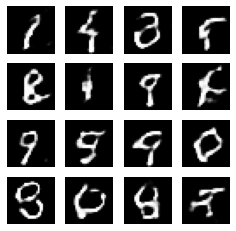

In [20]:
EPOCHS = 50
train(train_dataset, EPOCHS)

In [21]:
# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Create the progress GIF

One of the cooler parts of this tutorial, this section creates a gif using each of the example images produced during training.  Each example was generated using the same random seed, so we can clearly see the generated images becoming more and more distinct as each epoch was finished.

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

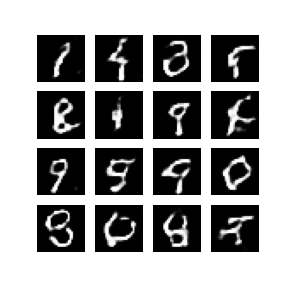

In [23]:
display_image(EPOCHS)

In [24]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [26]:
pip install -q git+https://github.com/tensorflow/docs


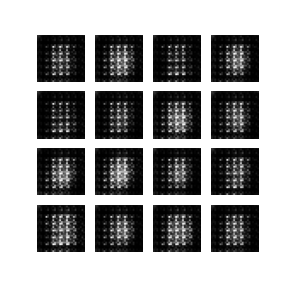

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)